### Deep Convolutional Generative Adversarial Networks (DCGAN)

[original paper](https://arxiv.org/abs/1511.06434) <br>
[keras example reference](https://keras.io/examples/generative/dcgan_overriding_train_step/)

#### Datasets:
[Celeb-a kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset)
[Google cartoon](https://google.github.io/cartoonset/download.html)

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# configure the GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [12]:
square_dims = 128
latent_size = int(square_dims/8)

In [20]:
dataset = keras.preprocessing.image_dataset_from_directory(
    directory="./dataset/cartoonset100k-small",
    labels=None,
    image_size=(square_dims, square_dims),
    batch_size=25,
    shuffle=True,
    color_mode="rgb",
).map(lambda x: x/255)

Found 5000 files belonging to 1 classes.


In [5]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(square_dims, square_dims, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)           

#### Conv2DTranspose -> Reverse Convolution
* upscaler
* used in encoder and decoder architecture as decompressor

In [13]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(latent_size * latent_size * 128),
        layers.Reshape((latent_size, latent_size, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32768)             4227072   
                                                                 
 reshape_6 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 64, 64, 256)      524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 64, 64, 256)       0 

In [14]:
from tqdm import tqdm

In [15]:
opt_gen = keras.optimizers.Adam(1e-4)
opt_disc = keras.optimizers.Adam(1e-4)
loss_fn = keras.losses.BinaryCrossentropy()

In [16]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [17]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"./generated/generated_img_{epoch}_{i}.png")

        # save the models
        self.model.generator.save(f"./models/DCGAN/generator/generator_{epoch}")
        self.model.discriminator.save(f"./models/DCGAN/dis/discriminator_{epoch}")

In [21]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[25,512,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/generator/conv2d_12/Conv2D_1/Conv2DBackpropInput
 (defined at C:\Users\vedan\AppData\Local\Temp/ipykernel_9516/63253887.py:58)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5061]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/generator/conv2d_12/Conv2D_1/Conv2DBackpropInput:
In[0] gradient_tape/generator/conv2d_12/Conv2D_1/ShapeN:	
In[1] generator/conv2d_12/Conv2D_1/ReadVariableOp (defined at C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\layers\convolutional.py:231)	
In[2] gradient_tape/generator/conv2d_12/Sigmoid_1/SigmoidGrad:

Operation defined at: (most recent call last)
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\kernelapp.py", line 667, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py", line 345, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Temp/ipykernel_9516/2676205370.py", line 10, in <module>
>>>     gan.fit(
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\vedan\AppData\Local\Temp/ipykernel_9516/63253887.py", line 58, in train_step
>>>     grads = tape.gradient(g_loss, self.generator.trainable_weights)
>>> 

In [2]:
generator = keras.models.load_model("./models/DCGAN/gen/generator_79")

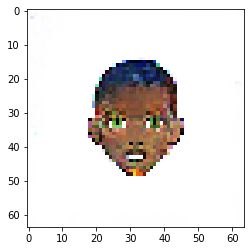

In [12]:
latent_dim = 128
random_vector = tf.random.normal(shape=(1, latent_dim))
output = generator(random_vector)
plt.imshow(output[0])